## Task:
  - Design and implement a class to store and evaluate a piecewise constant function.
  - Provide an evaluation function, i.e., to give its value (or fail) for any possible real number as input.
  - Provide a function to get its minimum value and argmin.
  - Provide a function to get its maximum value and argmax.
 
## Bonus points:
  - Provide sufficient correctness tests, using PyTest. Pay special attention to handling corner cases or bad input.
  - Provide sufficient timing tests. At which point your functions struggles down 
  - Under which scenario would the 3 class methods slow down ?
  - Provide a Jupyter notebook demonstrating the functionality of your class.
  - Repeat for for a piecewise linear function.

--------------------------------------------------------------------------------
## Design Choices:
  - For ease, this is done entirely in a single notebook. Normally this would be split in defferent .py scripts, each one for a class, utils, requirements etc.
  - If a range is wrong as in [2, 1] I chose to throw an exception.
  - If there is overlap, I throw an exception and delegate the issue to the caller.
  - I chose to create a internal private copy of the segments/pieces in order to not distrurb the original version of the calling user, but that can be changed easily for the sake of memory usage.
  - I assume the computation load is going to be in the evaluate function so I prepare the data in the constructor. For the use case of multiple objects created and the evaluate function going to be called only once per object a different implementation is going to be optimal.
  - If the number evaluated does not belong to a given range, I throw an exception.
  - In the future if this library proves useful we can choose to write a base class to derive children for different kinds of equations, or overload the same one.
  - For the linear version a variation point is whether we calculate the equation of the line in the contructor or in the evaluation point. It is understood that the is a small tradeoff of space because the line value have to be stored, but the computation of the line at the evaluation function is gained.
  - Instead of using linspace or range for the input, I chose to take in just the edges in order to be valid for all real numbers. Linspace and range are discrete.

## Optimization:
  - Search function, for now binary search but also a set has been considered due to $O(1)$ complexity but not chosen because it can only be unordered and the lookup gains are mitingated with the current list structure. Also interpolation search could be optimal for a certain distribution of ranges due to $O(loglogn)$ but covering all cases binary search is better due to $O(nlogn)$.
  - Computation load concentrated on constructor because of assumption of repeated use of evaluation function on each object.
  - In future versions, base class for any piecewise function could be built, and then constant, linear etc versions derived.
  - In both classes, in order to optimize the performance we could use numpy arrays instead of lists.
  - If we refactor the code to use numpy arrays, then we could gain extra speedup using numba/jit.

### Requirements
```
ipytest             0.13.0
matplotlib          3.2.2
numpy               1.21.6
pandas              1.3.5
pytest              7.2.0
scipy               1.7.3
session_info        1.0.0
```

# Demo

f(2.5) = 3
min = 1
argmin = 0
max = 5
argmax = 4


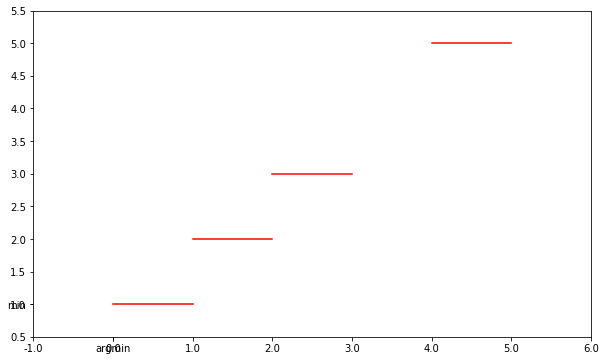

In [ ]:
# CONSTANT:
# we create the segments - this is for demonstration, there is also 
# a random segmment producer <rand_seg()>
segments = [[0,1,1], [1,2,2], [2,3,3], [4,5,5]]
# segments have the format [[fromA, toB, const],]
# then we initialize the class <PCF> with the previously defined segments
# and create the object <foo>
foo = PCF(segments, verbose = False)
# we can then call the evaluation function
foo.evaluate(2.5, verbose = True)
# and finally call <report()> on the object to visualize out results
foo.report()

f(2.5) = 2.5000000000000036
min = -2.220446049250313e-16
argmin = 1
max = 3.9999999999999982
argmax = 3


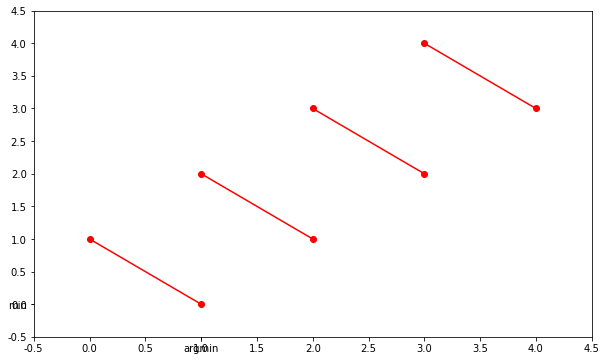

In [ ]:
# LINEAR:
# we create the segments - this is for demonstration, there is also 
# a random segmment producer <rand_seg()>
segments = [[0,1,(0,1), (1,0)], [1,2,(1,2), (2,1)], [2,3,(2,3),(3,2)], [4,5, (3,4), (4,3)]]
# segments have the format [[fromA, toB, (x1, y1), (x2, y2))],]
# then we initialize the class <PLF> with the previously defined segments
# and create the object <foo>
foo = PLF(segments, verbose = False)
# we can then call the evaluation function
foo.evaluate(2.5, verbose = True)
# and finally call <report()> on the object to visualize out results
foo.report()

# Implementation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint, uniform
import time
import copy
import pandas as pd
from sys import getsizeof
from numpy import ones,vstack
from numpy.linalg import lstsq
from numba import njit
from scipy.interpolate import make_interp_spline, BSpline
!pip install ipytest # notebook version of pytest
import ipytest
import pytest

ipytest.autoconfig()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Helper functions

In [ ]:
def binary_search(arr, x: float) -> float:
  """
  Iterative Binary Search, complexity O(nlogn)
  reference: https://www.geeksforgeeks.org/python-program-for-binary-search/

  Args:
    arr (ist): the list over which to search
    x (float): argument to search for in arr

  Returns:
    float: index of requested x
  """
  low = 0
  high = len(arr) - 1
  mid = 0
  while low <= high:
    mid = (high + low) // 2
    # If x is greater, ignore left half
    if arr[mid][1] < x:
      low = mid + 1
      # If x is smaller, ignore right half
    elif arr[mid][0] > x:
      high = mid - 1
    # means x is present at mid
    else:
      return mid
    # If we reach here, then the element was not present
  return -1

def rand_seg(start: float, end: float, num: float, type = float, mode: str = 'constant') -> list:
  """
  Returns example input for piecewise function in the format
    [[start, end, constant],]

  Args:
    start (float): start of the range
    end (float): end of the range
    num (float): range size
    type (=float): float type for output
    mode (str) (='constant'): choose mode of operation, 'constant' for PCF, 'linear' for PLF

  Returns:
    list: list of lists containing the segments
  """
  # choose appropriate calling function for random nums
  if type == int:
    func = randint
  elif type == float:
    func = uniform
  else:
    raise ValueError("Usage: value = int OR value = float.")
  segments = []
  j = 0
  for i in range(num):
    a = j + func(start, end)
    b = a + func(start, end)
    j = b
    if mode == 'constant':
      segments.append([a, b, func(start, end)])
    elif mode == 'linear':
      segments.append([a, b, (func(a, b), func(start, end)), (func(a, b), func(start, end))])
    else:
      raise ValueError("Usage: mode = 'constant' OR mode = 'linear'")
  return segments

## Error handling

In [ ]:
class RangeNotSorted(Exception):
    """Exception raised for errors in the range.

    Attributes:

    """

    def __init__(self, range, message=""):
        self.range = range
        self.message = message
        super().__init__(self.message)

    def __str__(self):
        return f'{self.range} -> {self.message}'

class RangeIntersection(Exception):
    """Exception raised for errors in the range.

    Attributes:

    """

    def __init__(self, range, message=""):
        self.range = range
        self.message = message
        super().__init__(self.message)

    def __str__(self):
        return f'{self.range} -> {self.message}'

class ValueNotInRange(Exception):
    """Exception raised for errors in the range.

    Attributes:

    """

    def __init__(self, range, message=""):
        self.range = range
        self.message = message
        super().__init__(self.message)

    def __str__(self):
        return f'{self.range} -> {self.message}'

## PCF

In [ ]:
class PCF:
  """
  Piecewise constant function class.

  Args:
    segments (list): List of lists with each item being the range 
      and constant value of each function. Syntax: [[start, end, constant],].
    verbose (=True): (bool) (optional) Include or not printouts.

  Attributes:
    __segs (list): list with [[start, end, constant],] format containing the function pieces
    my_min (float): global min
    my_argmin (float): global armin
    my_max (float): global max
    my_argmax (float): global argmax
  
  Functions:
    __init__(list, bool): Constructor.
    __preprocessing(): Function to be called in the constructor to make the input ready
      for later proessing, by checking for misaligned ranges, intersections,
      and finding min/argmin, max/argmax.
    __fill(): Fills in any gaps that are found between given ranges
      starting from -inf and ending at inf. In the "fake" ranges
      created, y is defined as NaN.
    evaluate(): Evaluates a number x, by searching for which piece of the piecewise
      function it belongs to, and returning the appropriate y.
    get_mins(): Returns global min of piecewise function.
    get_maxs(): Returns global max of piecewise function.
    plot(): Plots the pieces of the piecewise function.
    report(): Prints out the min/argmin and max/argmax and calls plot().
  """
  
  def __init__(self, segments: list, verbose: bool = True) -> None:
    # check if input is empty
    if not segments:
      raise ValueError("Segments is empty.")
    if not isinstance(segments, list):
        raise ValueError("Segments is not the correct type. Accepted: list")
    if not isinstance(segments[0][0], (int, float)):
        raise ValueError("Segments[o] is not the correct type. Accepted: int/float.")
    if len(segments[0]) > 3:
      raise ValueError(f"Segments is not configured corrently. Expected len(segments[0]) = 3 but got len(segments[0]) = {len(segments[0])}")
    # sort based on range start (x)
    self.__segs = sorted(segments, key = lambda x: min(x[0], x[1]))
    self.my_min, self.my_argmin, self.my_max, self.my_argmax = self.__preprocessing()
    self.__fill()
    if verbose == True:
      print(f'before {segments}')
      print(f'after {self.__segs}')

  def __preprocessing(self, check_swap = False) -> tuple:
    """
    Function to be called in the constructor to make the input ready
      for later proessing, by checking for misaligned ranges, intersections,
      and finding min/argmin, max/argmax. O(n) complexity.

    Attributes:
      check_swap (bool) (=False): checks and swaps if any ranges are in 
        incorrect order i.e. [2, 1]

    Returns:
      tuple: min, argmin, max, argmax
    """
    temp_min = self.__segs[0][2]
    temp_argmin = self.__segs[0][0]
    temp_max = self.__segs[0][2]
    temp_argmax = self.__segs[0][0]
    for i in range(len(self.__segs)):
      if check_swap == True:
      # check for ranges that need swapping
        if self.__segs[i][1] < self.__segs[i][0]:
          print(f"swapping {self.__segs[i][1]}, {self.__segs[i][0]}")
          temp = self.__segs[i][1]
          self.__segs[i][1] = self.__segs[i][0]
          self.__segs[i][0] = temp
      # now that they are aligned, check for intersection
      if i < len(self.__segs) - 1:
        if self.__segs[i][1] > self.__segs[i + 1][0]:
          raise RangeIntersection(f"""Range overlap between segments
            [{self.__segs[i][0], self.__segs[i][1]}] and 
            [{self.__segs[i + 1][0], self.__segs[i + 1][1]}].""")
      # find min/argmin
      if self.__segs[i][2] < temp_min:
        temp_min = self.__segs[i][2]
        temp_argmin = self.__segs[i][0]
      # find max/argmax
      if self.__segs[i][2] > temp_max:
        temp_max = self.__segs[i][2]
        temp_argmax = self.__segs[i][0]
      i += 1
    return temp_min, temp_argmin, temp_max, temp_argmax

  def __fill(self) -> None:
    """
    Fills in any gaps that are found between given ranges
      starting from -inf and ending at inf. In the "fake" ranges
      created, y is defined as NaN.

    Returns:
      None
    """
    # fill in gaps
    # if +/- inf does not already exist, add it to start/end of segments
    if self.__segs[0][0] != -np.inf:
      self.__segs.insert(0, [-np.inf, self.__segs[0][0], np.nan])
    if self.__segs[-1][1] != np.inf:
      self.__segs.append([self.__segs[-1][1], np.inf, np.nan])
    # for all segments check if end of segment matches the beginning of the next
    # if not func is non-continuous so insert a fake segment with NaN y
    for i in range(len(self.__segs) - 1):
      if self.__segs[i][1] != self.__segs[i + 1][0]:
        self.__segs.insert(i + 1, [self.__segs[i][1], self.__segs[i + 1][0], np.nan])

  def evaluate(self, x: float, verbose: bool = True) -> float:
    """
    Evaluates a number x, by searching for which piece of the piecewise
      function it belongs to, and returning the appropriate y. O(nlogn) complexity.

    Args:
      x (float): number to evaluate
      verbose (bool) (=True): printout preference

    Returns:
      None
    """
    # do it in C?
    # I assume inclusive (closed) brackets
    #ans = self.__segs[binary_search(np.array(self.__segs), x)][2] # O(nlogn), interpolation search better?
    ans = self.__segs[binary_search(self.__segs, x)][2] # O(nlogn), interpolation search better?
    if ans == np.nan:
      raise ValueNotInRange(f"{x} not found in given ranges.")
    if verbose == True:
      print(f'f({x}) = {ans}')
    return ans

  def get_mins(self) -> tuple:
    """
    Returns global min of piecewise function.

    Returns:
      tuple: global min/argmin
    """
    return self.my_min, self.my_argmin

  def get_maxs(self) -> tuple:
    """
    Returns global max of piecewise function.

    Returns:
      tuple: global max/argmax
    """
    return self.my_max, self.my_argmax
  
  def plot(self, limit=1000) -> None:
    """
    Plots the pieces of the piecewise function.

    Args:
      limit (int): limit on how many pieces to plot

    Returns:
      None
    """
    i = 0
    my_min, my_argmin = self.get_mins()
    my_max, my_argmax = self.get_maxs()
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for start, end, y in segments:
      x = np.linspace(start, end, 10)
      plt.plot(x, np.full(x.shape, y), color='r')
      if i > limit:
        break
    xt = ax.get_xticks() 
    xt = np.append(xt, my_argmin)
    xtl = xt.tolist()
    xtl[-1] = "argmin"
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)

    yt = ax.get_yticks() 
    yt = np.append(yt, my_min)
    ytl = yt.tolist()
    ytl[-1] = "min"
    ax.set_yticks(yt)
    ax.set_yticklabels(ytl)
      
  def report(self) -> None:
    """
    Prints out the min/argmin and max/argmax and calls plot().

    Returns:
      None
    """
    my_min, my_argmin = self.get_mins()
    my_max, my_argmax = self.get_maxs()
    print(f"min = {my_min}\nargmin = {my_argmin}\nmax = {my_max}\nargmax = {my_argmax}")
    self.plot()
    return

f(2.5) = 3
min = 1
argmin = 0
max = 5
argmax = 4


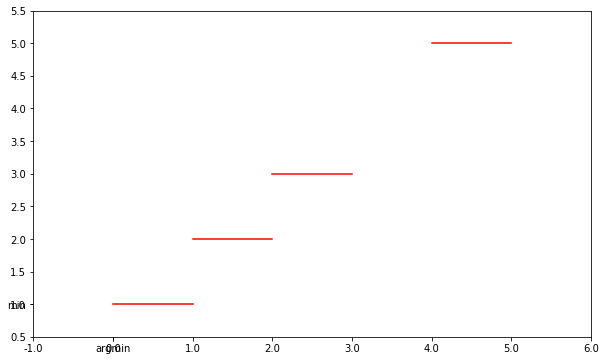

In [ ]:
#segments = rand_seg(0, 100, 10, float)
segments = [[0,1,1], [1,2,2], [2,3,3], [4,5,5]]
foo = PCF(segments, verbose = False)
foo.evaluate(2.5, verbose = True)
foo.report()

## PLF

In [ ]:
class PLF:
  """
  Piecewise linear function class.

  Args:
    segments (list): List of lists with each item being the range 
      and constant value of each function. Syntax: [[start, end, (x_1, y_1), (x_2, y_2)],]
      but syntax is extened after preprocessing to [[start, end, (x_1new, y_1new), (x_2new, y_2new)] a, b,]
      with x_{}new being the edges of the line calculated with the line equation
      and a, b froom y = ax + b.
    verbose (=True): (bool) (optional) Include or not printouts.

  Attributes:
    __segs (list): list with [[start, end, constant],] format containing the function pieces
    my_min (float): global min
    my_argmin (float): global armin
    my_max (float): global max
    my_argmax (float): global argmax
  
  Functions:
    __init__(list, bool): Constructor.
    __preprocessing(): Function to be called in the constructor to make the input ready
      for later proessing, by checking for misaligned ranges, intersections,
      and finding min/argmin, max/argmax.
    __fill(): Fills in any gaps that are found between given ranges
      starting from -inf and ending at inf. In the "fake" ranges
      created, y is defined as NaN.
    evaluate(): Evaluates a number x, by searching for which piece of the piecewise
      function it belongs to, and returning the appropriate y.
    get_mins(): Returns global min of piecewise function.
    get_maxs(): Returns global max of piecewise function.
    plot(): Plots the pieces of the piecewise function.
    report(): Prints out the min/argmin and max/argmax and calls plot().
  """

  def __init__(self, segments: list, verbose: bool = True) -> None:
    # check if input is empty
    if not segments:
      raise ValueError("Segments is empty")
    if not isinstance(segments, list):
        raise ValueError("Segments is not the correct type. Accepted: list")
    if not isinstance(segments[0][0], (int, float)):
        raise ValueError("Segments[o] is not the correct type. Accepted: int/float.")
    if len(segments[0]) >= 6:
      raise ValueError(f"Segments is not configured corrently. Expected len(segments[0]) = 4 but got len(segments[0]) = {len(segments[0])}")
    # sort based on range start
    # copy segments to a private variable
    self.__segs = copy.deepcopy(sorted(segments, key = lambda x: min(x[0], x[1])))
    self.my_min, self.my_argmin, self.my_max, self.my_argmax = self.__preprocessing()
    self.__fill()
    if verbose == True:
      print(f'before {segments}')
      print(f'after {self.__segs}')

  def __preprocessing(self, check_swap = False) -> tuple:
    """
    Function to be called in the constructor to make the input ready
      for later proessing, by checking for misaligned ranges, intersections,
      and finding min/argmin, max/argmax. O(n) complexity.

    Attributes:
      check_swap (bool) (=False): checks and swaps if any ranges are in 
        incorrect order i.e. [2, 1]

    Returns:
      tuple: min, argmin, max, argmax
    """
    temp_min = self.__segs[0][2][1]
    temp_argmin = self.__segs[0][2][0]
    temp_max = self.__segs[0][2][1]
    temp_argmax = self.__segs[0][2][0]
    for i in range(len(self.__segs)):
      if check_swap == True:
      # check for ranges that need swapping
        if self.__segs[i][1] < self.__segs[i][0]:
          print(f"swapping {self.__segs[i][1]}, {self.__segs[i][0]}")
          temp = self.__segs[i][1]
          self.__segs[i][1] = self.__segs[i][0]
          self.__segs[i][0] = temp
      # now that they are aligned, check for intersection
      if i < len(self.__segs) - 1:
        if self.__segs[i][1] > self.__segs[i + 1][0]:
          raise RangeIntersection(f"""Range overlap between segments
            [{self.__segs[i][0], self.__segs[i][1]}] and 
            [{self.__segs[i + 1][0], self.__segs[i + 1][1]}].""")
      # find linear equation
      p1, p2 = self.__segs[i][2:4]
      points = [p1, p2]
      # find y = ax + b
      x_coords, y_coords = zip(*points)
      A = vstack([x_coords,ones(len(x_coords))]).T
      a, b = lstsq(A, y_coords, rcond=None)[0]
      self.__segs[i].append(a)
      self.__segs[i].append(b)
      # replace points with true edges based on range and equation
      self.__segs[i][2] = (self.__segs[i][2][0], a * self.__segs[i][2][0] + b)
      self.__segs[i][3] = (self.__segs[i][3][0], a * self.__segs[i][3][0] + b)
      # find min/argmin
      _, right = zip(*self.__segs[i][2:4]) # get ys together
      index, local_min = right.index(min(right)), min(right) # find min y and its index
      index += 2 # translate index to segment index
      local_argmin = self.__segs[i][index][0] # get corresponding x
      if local_min < temp_min:
        temp_argmin = local_argmin
        temp_min = local_min
      # find max/argmax
      _, right = zip(*self.__segs[i][2:4]) # get ys together
      index, local_max = right.index(max(right)), max(right) # find max y and its index
      index += 2 # translate index to segment index
      local_argmax = self.__segs[i][index][0] # get corresponding x
      if local_max > temp_max:
        temp_argmax = local_argmax
        temp_max = local_max
      i += 1
    return temp_min, temp_argmin, temp_max, temp_argmax

  def __fill(self) -> None:
    """
    Fills in any gaps that are found between given ranges
      starting from -inf and ending at inf. In the "fake" ranges
      created, y is defined as NaN.

    Returns:
      None
    """
    # fill in gaps
    # if +/- inf does not already exist, add it to start/end of segments
    if self.__segs[0][0] != -np.inf:
      self.__segs.insert(0, [-np.inf, self.__segs[0][0], (np.nan, np.nan), (np.nan, np.nan)])
    if self.__segs[-1][1] != np.inf:
      self.__segs.append([self.__segs[-1][1], np.inf, np.nan, np.nan])
    # for all segments check if end of segment matches the beginning of the next
    # if not func is non-continuous so insert a fake segment with NaN y
    for i in range(len(self.__segs) - 1):
      if self.__segs[i][1] != self.__segs[i + 1][0]:
        self.__segs.insert(i + 1, [self.__segs[i][1], self.__segs[i + 1][0], (np.nan, np.nan), (np.nan, np.nan)])

  def evaluate(self, x: float, verbose: bool = True) -> float:
    """
    Evaluates a number x, by searching for which piece of the piecewise
      function it belongs to, and returning the appropriate y. O(nlogn) complexity.

    Args:
      x (float): number to evaluate
      verbose (bool) (=True): printout preference

    Returns:
      None
    """
    # do it in C?
    # I assume inclusive (closed) brackets
    # O(nlogn), interpolation search better?
    a, b = self.__segs[binary_search(self.__segs, x)][-2:]
    #if np.isnan(a):
    if np.isnan(a).any():
      raise ValueNotInRange(f"{x} not found in given ranges.")
      #return np.nan
    ans = a * x + b
    if verbose == True:
      print(f'f({x}) = {ans}')
    return ans

  def get_mins(self) -> tuple:
    """
    Returns global min of piecewise function.

    Returns:
      tuple: global min/argmin
    """
    return self.my_min, self.my_argmin

  def get_maxs(self) -> tuple:
    """
    Returns global max of piecewise function.

    Returns:
      tuple: global max/argmax
    """
    return self.my_max, self.my_argmax

  def plot(self, limit=100) -> None:
    """
    Plots the pieces of the piecewise function.

    Args:
      limit (int): limit on how many pieces to plot

    Returns:
      None
    """
    for item in self.__segs: # remove NaNs
      if len(item) == 4:
        self.__segs.remove(item)
    my_min, my_argmin = self.get_mins()
    my_max, my_argmax = self.get_maxs()
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    i = 0
    for start, end, p1, p2, _, _ in self.__segs:
      plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'ro-')
      if i > limit:
        break
    xt = ax.get_xticks() 
    xt = np.append(xt, my_argmin)
    xtl = xt.tolist()
    xtl[-1] = "argmin"
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)

    yt = ax.get_yticks() 
    yt = np.append(yt, my_min)
    ytl = yt.tolist()
    ytl[-1] = "min"
    ax.set_yticks(yt)
    ax.set_yticklabels(ytl)

  def report(self) -> None:
    """
    Prints out the min/argmin and max/argmax and calls plot().

    Returns:
      None
    """
    my_min, my_argmin = self.get_mins()
    my_max, my_argmax = self.get_maxs()
    print(f"min = {my_min}\nargmin = {my_argmin}\nmax = {my_max}\nargmax = {my_argmax}")
    self.plot()
    return

f(1.5) = 1.5000000000000016
min = -2.220446049250313e-16
argmin = 1
max = 3.9999999999999982
argmax = 3


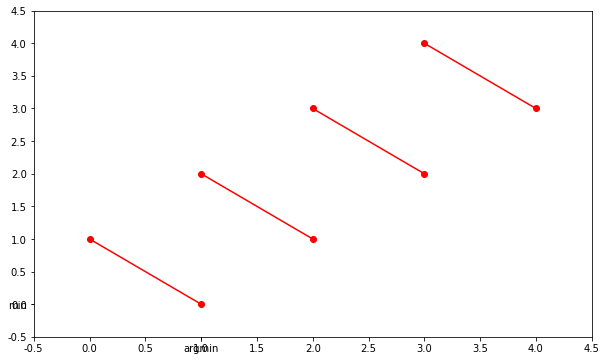

In [ ]:
#segments = rand_seg(0, 100, 10, int, 'linear')
segments = [[0,1,(0,1), (1,0)], [1,2,(1,2), (2,1)], [2,3,(2,3),(3,2)], [4,5, (3,4), (4,3)]]
foo = PLF(segments, verbose = False)
foo.evaluate(1.5, verbose = True)
foo.report()

## Scaling Study

In [ ]:
# PCF obj creation
segments = rand_seg(0, 100, 100, float, 'constant')
%timeit -n 10000 foo = PCF(segments,  verbose=False)

128 µs ± 4.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# PCF obj evaluation
%%timeit -n 10000
try:
  foo.evaluate(randint(0, 100), verbose=False)
except ValueNotInRange:
  pass

8.92 µs ± 610 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# PLF obj creation
segments = rand_seg(0, 100, 100, float, 'linear')
%timeit -n 1000 foo = PLF(segments,  verbose=False)

8.27 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# PLF obj evaluation
%%timeit -n 1000
try:
  foo.evaluate(randint(0, 100), verbose=False)
except ValueNotInRange:
  pass

10.4 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Text(0.5, 1.0, 'PCF - obj evaluation')

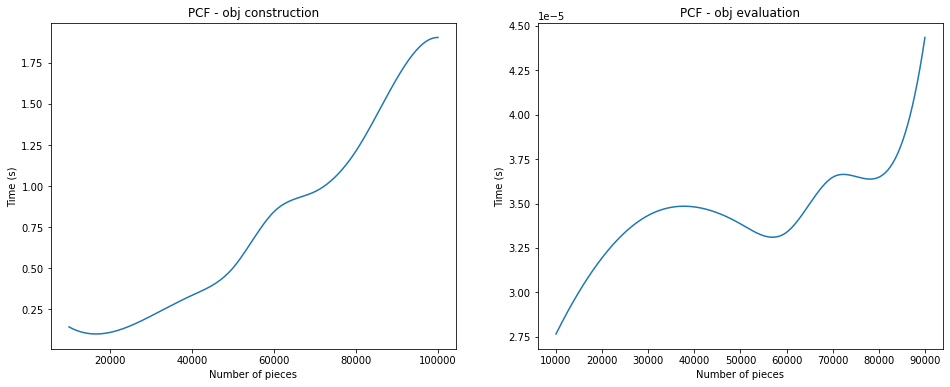

In [ ]:
# PCF
size = []
tt = []
disk = []

segments = []
a = 10
for i in range(100000):
  segments.append([a, a + 10, i])
  a += 20

for i in range(10000, 110000, 10000):
  #segments = rand_seg(0, 100, i, float)
  temp_seg = segments[:i]
  disk.append(getsizeof(temp_seg))
  size.append(i)
  start_time = time.time()
  foo = PCF(temp_seg, verbose=False)
  dur = time.time() - start_time
  tt.append(dur)
  del foo
dfcon = pd.DataFrame(columns = ['size', 'disk', 'time'])
dfcon.size = size
dfcon.time = tt
dfcon.disk = disk

size = []
tt = []
disk = []
for i in range(10000, 100000, 10000):
  #segments = rand_seg(0, 100, i, float)
  temp_seg = segments[:i]
  disk.append(getsizeof(temp_seg))
  size.append(i)
  foo = PCF(temp_seg, verbose=False)
  start_time = time.time()
  foo.evaluate(i, verbose = False)
  dur = time.time() - start_time
  tt.append(dur)
dfeval = pd.DataFrame(columns = ['size', 'disk', 'time'])
dfeval.size = size
dfeval.time = tt
dfeval.disk = disk


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121) 

xnew = np.linspace(dfcon['size'].min(), dfcon['size'].max(), 300)
spl = make_interp_spline(dfcon['size'], dfcon.time, k=3)
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Number of pieces")
plt.ylabel("Time (s)")
plt.title("PCF - obj construction")

ax = fig.add_subplot(122)
#ax.set_yscale('log')
xnew = np.linspace(dfeval['size'].min(), dfeval['size'].max(), 300)
spl = make_interp_spline(dfeval['size'], dfeval.time, k=3)
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Number of pieces")
plt.ylabel("Time (s)")
plt.title("PCF - obj evaluation")

Text(0.5, 1.0, 'PLF - obj evaluation')

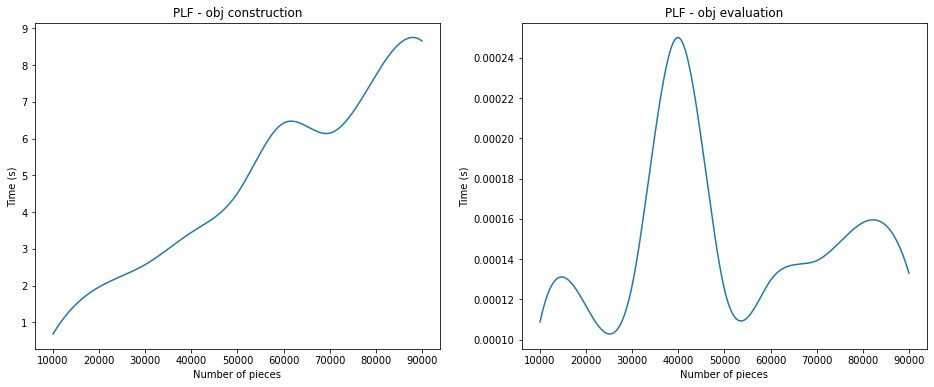

In [ ]:
# PLF
size = []
tt = []
disk = []

segments = []
a = 10
for i in range(100000):
  segments.append([a, a + 10, (i, i + 1), (i + 1, i)])
  a += 20

for i in range(10000, 100000, 10000):
  #segments = rand_seg(0, 100, i, float, 'linear')
  temp_seg = segments[:i]
  disk.append(getsizeof(temp_seg))
  size.append(i)
  start_time = time.time()
  foo = PLF(temp_seg, verbose=False)
  dur = time.time() - start_time
  tt.append(dur)
  del foo
dfcon = pd.DataFrame(columns = ['size', 'disk', 'time'])
dfcon.size = size
dfcon.time = tt
dfcon.disk = disk

size = []
tt = []
disk = []
for i in range(10000, 100000, 10000):
  #segments = rand_seg(0, 100, i, float, 'linear')
  temp_seg = segments[:i]
  disk.append(getsizeof(temp_seg))
  size.append(i)
  foo = PLF(temp_seg, verbose=False)
  start_time = time.time()
  try:
    foo.evaluate(i, verbose = False)
  except ValueNotInRange:
    pass
  dur = time.time() - start_time
  tt.append(dur)
dfeval = pd.DataFrame(columns = ['size', 'disk', 'time'])
dfeval.size = size
dfeval.time = tt
dfeval.disk = disk

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121) 

xnew = np.linspace(dfcon['size'].min(), dfcon['size'].max(), 300)
spl = make_interp_spline(dfcon['size'], dfcon.time, k=3)
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Number of pieces")
plt.ylabel("Time (s)")
plt.title("PLF - obj construction")

ax = fig.add_subplot(122)

xnew = np.linspace(dfeval['size'].min(), dfeval['size'].max(), 300)
spl = make_interp_spline(dfeval['size'], dfeval.time, k=3)
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Number of pieces")
plt.ylabel("Time (s)")
plt.title("PLF - obj evaluation")

# Unit Tests

### PCF Tests

In [ ]:
%%ipytest

def test_constant_int():
  segments = [[49, 137, 5],
    [190, 197, 70],
    [268, 312, 97],
    [380, 406, 75],
    [500, 564, 80],
    [659, 719, 80],
    [800, 877, 31],
    [937, 1020, 59],
    [1067, 1072, 1],
    [1086, 1091, 3]]
  foo = PCF(segments, verbose=False)
  assert foo.evaluate(98, verbose=False) == 5

def test_constant_float():
  segments = [[38.65433548255448, 105.99110488275198, 64.2814350233044],
 [179.37664884385256, 235.9274732779227, 42.47344468499347],
 [271.01347698245314, 356.36826000729286, 10.183315462346055],
 [397.75359430476135, 422.2658597808539, 80.97059615189706],
 [425.3651354513574, 448.37085953465225, 36.367754845635744],
 [477.23359513951334, 536.498356710656, 36.57638646872503],
 [603.7110411994475, 620.2891298268797, 42.97130009390834],
 [696.2133921113203, 762.704062395386, 22.512117892395487],
 [829.3665613242625, 898.0328846205599, 94.88624848735682],
 [915.4362235291002, 970.798377860121, 69.7359567593277]]
  foo = PCF(segments, verbose=False)
  assert foo.evaluate(98, verbose=False) == 64.2814350233044

def test_constant_out_of_range():
  segments = rand_seg(0, 100, 10, float)
  foo = PCF(segments, verbose=False)
  assert np.isnan(foo.evaluate(-1, verbose=False))

def test_constant_not_sorted():
  segments = [[49, 137, 5],
    [1067, 1072, 1],
    [190, 197, 70],
    [659, 719, 80],
    [268, 312, 97],
    [380, 406, 75],
    [500, 564, 80],
    [800, 877, 31],
    [937, 1020, 59],
    [1086, 1091, 3]]
  foo = PCF(segments, verbose=False)
  assert foo.evaluate(98, verbose=False) == 5

def test_constant_with_overlap():
  segments = [[49, 197, 5],
    [190, 197, 70],
    [268, 312, 97],
    [380, 406, 75],
    [500, 564, 80],
    [659, 719, 80],
    [800, 877, 31],
    [937, 1020, 59],
    [1092, 1072, 1],
    [1086, 1091, 3]]
  with pytest.raises(RangeIntersection):
    foo = PCF(segments, verbose=False)

def test_constant_not_sorted_with_overlap():
  segments = [[49, 197, 5],
    [380, 406, 75],
    [190, 197, 70],
    [268, 312, 97],
    [500, 564, 80],
    [1092, 1072, 1],
    [659, 719, 80],
    [800, 877, 31],
    [937, 1020, 59],
    [1086, 1091, 3]]
  with pytest.raises(RangeIntersection):
    foo = PCF(segments, verbose=False)

def test_constant_empty():
  segments = []
  with pytest.raises(ValueError):
    foo = PCF(segments, verbose=False)

def test_constant_str():
  segments = 'asd'
  with pytest.raises(ValueError):
    foo = PCF(segments, verbose=False)

def test_constant_str_list():
  segments = [['asd']]
  with pytest.raises(ValueError):
    foo = PCF(segments, verbose=False)

def test_constant_array():
  segments = np.array([1,2,3])
  with pytest.raises(ValueError):
    foo = PCF(segments, verbose=False)

# nans, swapped, timeit perf test (rel)

..........                                                                                   [100%]
10 passed in 0.07s


### PLF Tests

In [ ]:
%%ipytest

def test_linear_int():
  segments = [[24, 106, (84, 30), (103, 22)],
  [160, 179, (166, 70), (168, 1)],
  [225, 283, (279, 36), (244, 91)],
  [374, 376, (374, 90), (375, 50)],
  [437, 465, (457, 44), (447, 96)],
  [506, 550, (506, 45), (526, 87)],
  [638, 669, (667, 32), (650, 74)],
  [708, 728, (721, 45), (713, 25)],
  [794, 847, (802, 100), (802, 6)],
  [914, 946, (941, 40), (932, 55)]]
  foo = PLF(segments, verbose=False)
  assert foo.evaluate(86, verbose=False) == 29.157894736842124

def test_linear_float():
  segments = [[61.608719437502955,
  94.61824510396768,
  (86.67012208638081, 54.526436543080926),
  (92.53495492884417, 38.548086775060334)],
 [98.67457628632485,
  165.9780105006286,
  (132.51040269032995, 35.16607000475233),
  (159.804350569375, 72.41821301229903)],
 [249.052759103968,
  323.01571697466835,
  (320.820903184191, 13.18219707517272),
  (270.8134008818019, 56.165277391006285)],
 [398.7774277764288,
  427.66161488222315,
  (423.73104200670593, 78.72331740592399),
  (418.53635565359195, 23.544107400794566)],
 [465.4619559078917,
  514.1074514666584,
  (508.66338871361376, 59.9079935216293),
  (467.84400209723896, 99.39817370941016)],
 [581.6787922831787,
  600.7628568942657,
  (596.7339386782829, 0.29051318319248676),
  (583.1566061623637, 28.4292067882828)],
 [649.8217683943182,
  696.7886504186855,
  (695.596038851046, 73.59042293422957),
  (673.7131526210153, 98.79621515948085)],
 [762.328829905052,
  805.3501679028484,
  (788.8140945264776, 36.47436656383015),
  (766.7694246316986, 24.831062277925618)],
 [844.9896405595892,
  902.8602815545727,
  (847.8169475489244, 80.06458909115497),
  (851.6367359797382, 32.90096533865319)],
 [922.4836198432666,
  931.381550669958,
  (924.7493221930534, 16.534676824469564),
  (923.8675786103917, 11.157236357862278)]]
  foo = PLF(segments, verbose=False)
  assert foo.evaluate(86, verbose=False) == 56.3521399128245

def test_linear_out_of_range():
  segments = [[24, 106, (84, 30), (103, 22)],
  [160, 179, (166, 70), (168, 1)],
  [225, 283, (279, 36), (244, 91)],
  [374, 376, (374, 90), (375, 50)],
  [437, 465, (457, 44), (447, 96)],
  [506, 550, (506, 45), (526, 87)],
  [638, 669, (667, 32), (650, 74)],
  [708, 728, (721, 45), (713, 25)],
  [794, 847, (802, 100), (802, 6)],
  [914, 946, (941, 40), (932, 55)]]
  foo = PLF(segments, verbose=False)
  with pytest.raises(ValueNotInRange):
    foo.evaluate(-1, verbose=False)

def test_linear_not_sorted():
  segments = [[24, 106, (84, 30), (103, 22)],
  [160, 179, (166, 70), (168, 1)],
  [638, 669, (667, 32), (650, 74)],
  [225, 283, (279, 36), (244, 91)],
  [374, 376, (374, 90), (375, 50)],
  [794, 847, (802, 100), (802, 6)],
  [437, 465, (457, 44), (447, 96)],
  [506, 550, (506, 45), (526, 87)],
  [708, 728, (721, 45), (713, 25)],
  [914, 946, (941, 40), (932, 55)]]
  foo = PLF(segments, verbose=False)
  assert foo.evaluate(86, verbose=False) == 29.157894736842124

def test_linear_with_overlap():
  segments = [[24, 166, (84, 30), (103, 22)],
  [160, 179, (166, 70), (168, 1)],
  [638, 669, (667, 32), (650, 74)],
  [225, 283, (279, 36), (244, 91)],
  [374, 376, (374, 90), (375, 50)],
  [794, 847, (802, 100), (802, 6)],
  [437, 465, (457, 44), (447, 96)],
  [506, 550, (506, 45), (526, 87)],
  [708, 728, (721, 45), (713, 25)],
  [914, 946, (941, 40), (932, 55)]]
  with pytest.raises(RangeIntersection):
    foo = PLF(segments, verbose=False)

def test_linear_not_sorted_with_overlap():
  segments = [[24, 166, (84, 30), (103, 22)],
  [160, 179, (166, 70), (168, 1)],
  [437, 465, (457, 44), (447, 96)],
  [638, 669, (667, 32), (650, 74)],
  [225, 283, (279, 36), (244, 91)],
  [374, 376, (374, 90), (375, 50)],
  [794, 847, (802, 100), (802, 6)],
  [506, 550, (506, 45), (526, 87)],
  [708, 728, (721, 45), (713, 25)],
  [914, 946, (941, 40), (932, 55)]]
  with pytest.raises(RangeIntersection):
    foo = PLF(segments, verbose=False)

def test_linear_empty():
  segments = []
  with pytest.raises(ValueError):
    foo = PLF(segments, verbose=False)

def test_linear_str():
  segments = 'asd'
  with pytest.raises(ValueError):
    foo = PLF(segments, verbose=False)

def test_linear_str_list():
  segments = [['asd']]
  with pytest.raises(ValueError):
    foo = PLF(segments, verbose=False)

def test_linear_array():
  segments = np.array([1,2,3])
  with pytest.raises(ValueError):
    foo = PLF(segments, verbose=False)

# nans, swapped, timeit perf test (rel)

..........                                                                                   [100%]
10 passed in 0.07s
